# Debugging Door Extraction Logic

This notebook breaks down the `solve_door_extraction` function into individual steps using real data from the pipeline.

**Goal:** Extract a door from an image using a bounding box and a mask from `segmentation_results.json`, then warp it to a flat perspective and enhance the details.

In [1]:
import base64
import json
import io
import cv2
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import sys
import math

# Ensure we can import from the current directory
sys.path.append(os.getcwd())

# specific import for optional re-run
try:
    from new_segment import extract_segmentation_masks
except ImportError:
    print("Warning: Could not import 'extract_segmentation_masks' from 'new_segment.py'.")

# Helper to display images in Jupyter
def show_img(img, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    if len(img.shape) == 3:
        # Convert BGR to RGB for matplotlib
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap or 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

## 1. Setup Data & Image

We load the image `../sample_door_photos/IMG_3104.jpeg` and the JSON output from `segmentation_outputs/segmentation_results.json`.

Loaded image: ../sample_door_photos/IMG_3104.jpeg (3024x4032)


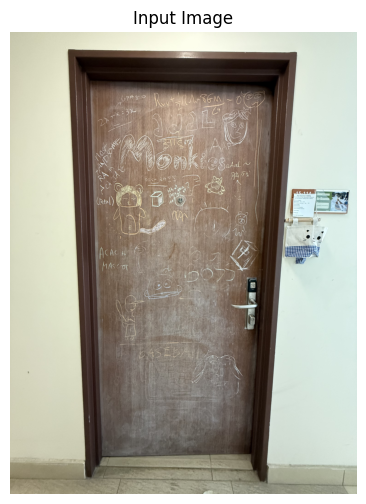

Loaded JSON data with 1 items.


In [2]:
# Configuration
image_path = '../sample_door_photos/IMG_3104.jpeg'
json_path = 'segmentation_outputs/segmentation_results.json'

# Optional: Re-run segmentation if you want to regenerate the JSON
RERUN_SEGMENTATION = False

if RERUN_SEGMENTATION:
    print("Re-running segmentation...")
    extract_segmentation_masks(image_path)
    print("Segmentation complete.")

# Load Image with EXIF Handling
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at {image_path}")

# Use PIL to load and fix orientation, then convert to OpenCV format
pil_img = Image.open(image_path)
pil_img = ImageOps.exif_transpose(pil_img)
original_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

img_h, img_w = original_img.shape[:2]
print(f"Loaded image: {image_path} ({img_w}x{img_h})")
show_img(original_img, "Input Image")

# Load JSON
if not os.path.exists(json_path):
    raise FileNotFoundError(f"JSON results not found at {json_path}. Run segmentation first or set RERUN_SEGMENTATION=True.")

with open(json_path, 'r') as f:
    json_data = json.load(f)

print(f"Loaded JSON data with {len(json_data)} items.")

## 2. Parse JSON & Handle Coordinates
We process the first item in the JSON list.

Processing item: the door excluding the doorframe
Bounding Box: (695, 435) to (2283, 3697)
Dimensions: 1588x3262


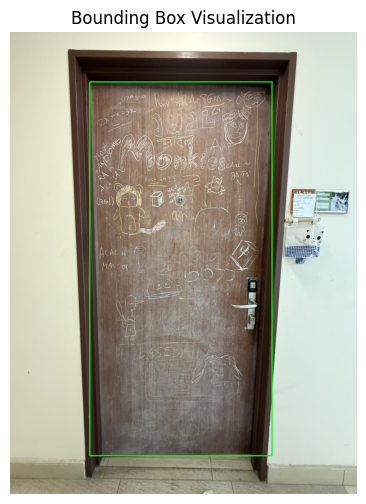

In [3]:
# Parse JSON
item = json_data[0]
box = item['box_2d'] 
label = item.get('label', 'unknown')
print(f"Processing item: {label}")

# Gemini API Standard: [ymin, xmin, ymax, xmax] (Normalized 0-1000)
ymin_norm, xmin_norm, ymax_norm, xmax_norm = box

# Denormalize to Absolute Pixels
y1 = int((ymin_norm / 1000) * img_h)
x1 = int((xmin_norm / 1000) * img_w)
y2 = int((ymax_norm / 1000) * img_h)
x2 = int((xmax_norm / 1000) * img_w)

# Safety clamp
x1, y1 = max(0, x1), max(0, y1)
x2, y2 = min(img_w, x2), min(img_h, y2)

box_w = x2 - x1
box_h = y2 - y1

print(f"Bounding Box: ({x1}, {y1}) to ({x2}, {y2})")
print(f"Dimensions: {box_w}x{box_h}")

if box_w <= 0 or box_h <= 0:
    raise ValueError("Invalid bounding box dimensions detected.")

# Visualize Bounding Box
debug_img = original_img.copy()
cv2.rectangle(debug_img, (x1, y1), (x2, y2), (0, 255, 0), 10)
show_img(debug_img, "Bounding Box Visualization")

## 3. Process Mask

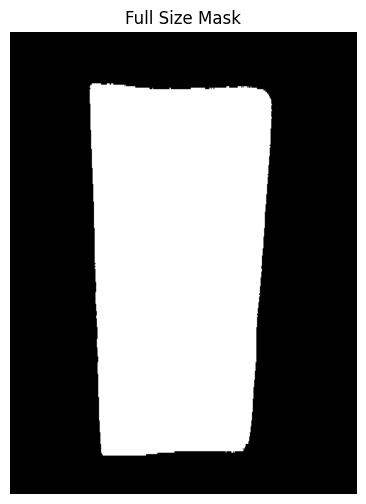

In [4]:
if 'mask' not in item:
    raise ValueError("No 'mask' field found in the item.")

mask_data = item['mask']
if mask_data.startswith('data:'):
    mask_data = mask_data.split(',', 1)[1]

mask_bytes = base64.b64decode(mask_data)
mask_pil = Image.open(io.BytesIO(mask_bytes))

# Resize mask to fit the absolute bounding box
mask_pil = mask_pil.resize((box_w, box_h), resample=Image.NEAREST)
mask_crop = np.array(mask_pil)

# Create Full-Size Mask
full_mask = np.zeros((img_h, img_w), dtype=np.uint8)
full_mask[y1:y2, x1:x2] = mask_crop

show_img(full_mask, "Full Size Mask", cmap='gray')

## 4. Corner Detection (Original Method)

Detected Corners: [[ 714  448]
 [ 794 3671]
 [2034 3658]
 [2276  588]]


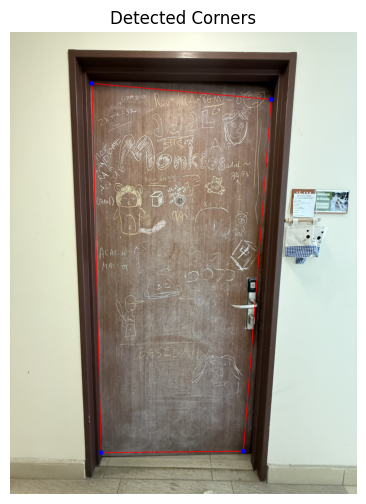

In [9]:
# Find contours in the full mask
contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No contours found in mask.")

# Get largest contour (the door)
cnt = max(contours, key=cv2.contourArea)

# Approximate the contour to a polygon (Rectangle = 4 points)
epsilon = 0.02 * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

# If approximation failed to get 4 points, use the bounding rect or convex hull
if len(approx) != 4:
    print(f"Info: approxPolyDP returned {len(approx)} points. Falling back to minAreaRect.")
    # Fallback: Just use the bounding box corners if shape is too irregular
    rect = cv2.minAreaRect(cnt)
    box_pts = cv2.boxPoints(rect)
    approx = np.int0(box_pts)

# Reshape to (4, 2)
pts = approx.reshape(4, 2)

print("Detected Corners:", pts)

# Visualize Corners
vis_corners = original_img.copy()
cv2.drawContours(vis_corners, [approx], -1, (0, 0, 255), 5)
for p in pts:
    cv2.circle(vis_corners, tuple(p), 20, (255, 0, 0), -1)
show_img(vis_corners, "Detected Corners")

## 5. Manual Adjustment

In [10]:
import numpy as np
import cv2
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
import io

# Initial sorting (TL, TR, BR, BL)
def sort_points(points):
    points = points[np.argsort(points[:, 1])] # Sort by Y
    top = points[:2]
    bottom = points[2:]
    top = top[np.argsort(top[:, 0])] # Sort top by X
    bottom = bottom[np.argsort(bottom[:, 0])] # Sort bottom by X
    tl, tr = top
    bl, br = bottom
    return np.array([tl, tr, br, bl])

# Check if 'pts' exists from previous step, otherwise fallback
if 'pts' in locals() and len(pts) == 4:
    sorted_pts = sort_points(pts)
else:
    # Fallback to bbox if detection failed or pts not defined
    if 'cnt' in locals():
        rect = cv2.minAreaRect(cnt)
        box_pts = np.int0(cv2.boxPoints(rect))
        sorted_pts = sort_points(box_pts)
    else:
        # Dummy points if nothing found
        sorted_pts = np.array([[0,0], [100,0], [100,100], [0,100]])

labels = ['TL', 'TR', 'BR', 'BL']
src_pts = sorted_pts.copy().astype(float)

# Convert image to RGB for matplotlib
img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Create widgets for draggable interface
image_output = widgets.Output()
status_label = widgets.HTML(value="<b>Click and drag the sliders, or type coordinates directly</b>")

# Create sliders for each point
sliders = {}
h, w = original_img.shape[:2]

for i, label in enumerate(labels):
    sliders[f'{label}_x'] = widgets.IntSlider(
        value=int(src_pts[i][0]), min=0, max=w, 
        description=f'{label} X', 
        style={'description_width': '50px'},
        layout=widgets.Layout(width='500px')
    )
    sliders[f'{label}_y'] = widgets.IntSlider(
        value=int(src_pts[i][1]), min=0, max=h, 
        description=f'{label} Y',
        style={'description_width': '50px'},
        layout=widgets.Layout(width='500px')
    )

def update_image(**kwargs):
    """Update the displayed image with new corner positions"""
    global src_pts
    
    # Update src_pts from slider values
    for i, label in enumerate(labels):
        src_pts[i][0] = kwargs[f'{label}_x']
        src_pts[i][1] = kwargs[f'{label}_y']
    
    # Create visualization
    img_copy = img_rgb.copy()
    
    # Draw polygon (convert to int for drawing)
    pts_int = src_pts.astype(np.int32)
    cv2.polylines(img_copy, [pts_int], isClosed=True, color=(0, 255, 0), thickness=3)
    
    # Draw circles and labels at corners
    for i, (pt, label) in enumerate(zip(pts_int, labels)):
        cv2.circle(img_copy, tuple(pt), 15, (255, 0, 0), -1)
        cv2.putText(img_copy, label, (pt[0] - 20, pt[1] - 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Display using matplotlib
    with image_output:
        image_output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(img_copy)
        ax.set_title("Adjust corner positions using sliders below", fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

# Create interactive controls
interactive = widgets.interactive(update_image, **sliders)

# Layout: stack sliders in pairs (X and Y for each corner)
slider_boxes = []
for label in labels:
    box = widgets.VBox([
        widgets.HTML(value=f"<h4>{label} Corner</h4>"),
        sliders[f'{label}_x'],
        sliders[f'{label}_y']
    ])
    slider_boxes.append(box)

# Arrange in 2x2 grid
top_row = widgets.HBox([slider_boxes[0], slider_boxes[1]])
bottom_row = widgets.HBox([slider_boxes[2], slider_boxes[3]])
controls = widgets.VBox([top_row, bottom_row])

# Display everything
display(widgets.VBox([
    status_label,
    image_output,
    controls
]))

# Trigger initial render
update_image(**{k: v.value for k, v in sliders.items()})

print("✓ Corner adjustment interface ready")
print("  - Drag sliders to adjust corner positions")
print("  - Changes appear in real-time above")
print(f"  - Current points: {src_pts.astype(int)}")

✓ Corner adjustment interface ready
  - Drag sliders to adjust corner positions
  - Changes appear in real-time above
  - Current points: [[ 714  448]
 [2276  588]
 [2034 3658]
 [ 794 3671]]


## 6. Order Points & Perspective Warp

Warping to door aspect ratio 3:7
Output size: 1200x2800 pixels


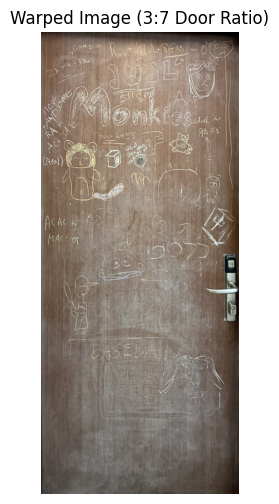

In [88]:
# Fixed output resolution (3:7 door aspect ratio)
out_w = 1200
out_h = 2800

print(f"Warping to door aspect ratio 3:7")
print(f"Output size: {out_w}x{out_h} pixels")

dst_pts = np.array([
    [0, 0],
    [out_w - 1, 0],
    [out_w - 1, out_h - 1],
    [0, out_h - 1]], dtype = "float32")
    
# Use the src_pts float32 for transform
M = cv2.getPerspectiveTransform(src_pts.astype("float32"), dst_pts)
warped_img = cv2.warpPerspective(original_img, M, (out_w, out_h))

show_img(warped_img, "Warped Image (3:7 Door Ratio)")

## 7. Chalk Extraction

### Top-Hat Morphological Transform

### Enhanced Chalk Extraction (Improved Contrast & Thickness)

In [89]:
# ==============================================================================
# ENHANCEMENT CONTROL PANEL - Toggle features on/off to experiment
# ==============================================================================
ENABLE_DILATION = False           # Make chalk lines thicker
ENABLE_MORPHOLOGICAL_CLOSING = False  # Connect nearby chalk strokes
ENABLE_CLAHE = False              # Improve contrast
ENABLE_SATURATION_BOOST = True   # Make colors more vivid

# Tuning parameters (adjust these if features are enabled)
DILATION_KERNEL_SIZE = (2, 2)    # Larger = thicker lines
DILATION_ITERATIONS = 2          # More iterations = even thicker
CLOSING_KERNEL_SIZE = (2, 2)     # Kernel for morphological closing
SATURATION_MULTIPLIER = 1.25      # 1.0 = no change, 2.0 = double saturation

print("Enhancement Settings:")
print(f"  • Dilation: {'ON' if ENABLE_DILATION else 'OFF'}")
print(f"  • Morphological Closing: {'ON' if ENABLE_MORPHOLOGICAL_CLOSING else 'OFF'}")
print(f"  • CLAHE Contrast: {'ON' if ENABLE_CLAHE else 'OFF'}")
print(f"  • Saturation Boost: {'ON' if ENABLE_SATURATION_BOOST else 'OFF'}")
print()

Enhancement Settings:
  • Dilation: OFF
  • Morphological Closing: OFF
  • CLAHE Contrast: OFF
  • Saturation Boost: ON



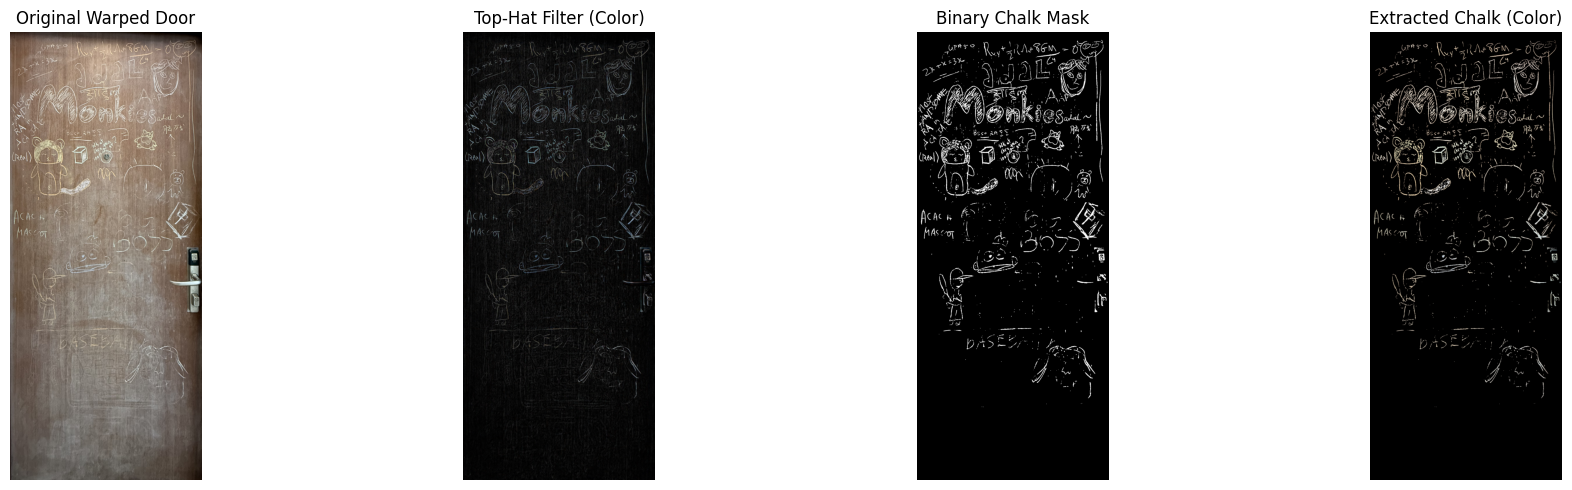

✓ Top-Hat chalk extraction complete


In [90]:
def extract_chalk_tophat(img):
    """
    Extract chalk markings using Top-Hat morphological transform.
    
    Args:
        img: BGR image (from cv2)
    
    Returns:
        tophat_color: The top-hat filtered result in color
        binary: Binary mask of chalk markings
        chalk_color: Color image showing only chalk regions
    """
    # Convert to grayscale for mask generation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Define a kernel size slightly larger than the thickness of chalk lines
    # Increase this if your chalk lines are very thick
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    
    # 2. Apply Top-Hat on grayscale to get mask
    # This isolates small bright features (chalk) from dark backgrounds (door)
    tophat_gray = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    
    # 3. Use Otsu's Thresholding to create binary mask
    _, binary = cv2.threshold(tophat_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4. Clean up stray noise with a small opening operation
    clean_kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, clean_kernel)
    
    # 5. Apply Top-Hat to each color channel separately to preserve color
    tophat_color = np.zeros_like(img)
    for i in range(3):  # B, G, R channels
        tophat_color[:, :, i] = cv2.morphologyEx(img[:, :, i], cv2.MORPH_TOPHAT, kernel)
    
    # 6. Extract colored chalk regions using the binary mask
    chalk_color = cv2.bitwise_and(img, img, mask=binary)
    
    return tophat_color, binary, chalk_color

# Run Top-Hat extraction on warped image
tophat_color, tophat_binary, chalk_color = extract_chalk_tophat(warped_img)

# Display results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Warped Door")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(tophat_color, cv2.COLOR_BGR2RGB))
axes[1].set_title("Top-Hat Filter (Color)")
axes[1].axis('off')

axes[2].imshow(tophat_binary, cmap='gray')
axes[2].set_title("Binary Chalk Mask")
axes[2].axis('off')

axes[3].imshow(cv2.cvtColor(chalk_color, cv2.COLOR_BGR2RGB))
axes[3].set_title("Extracted Chalk (Color)")
axes[3].axis('off')

plt.tight_layout()
plt.show()

print("✓ Top-Hat chalk extraction complete")

Applying enhancements...
  ⊗ Skipped dilation
  ⊗ Skipped morphological closing
  ⊗ Skipped CLAHE contrast enhancement


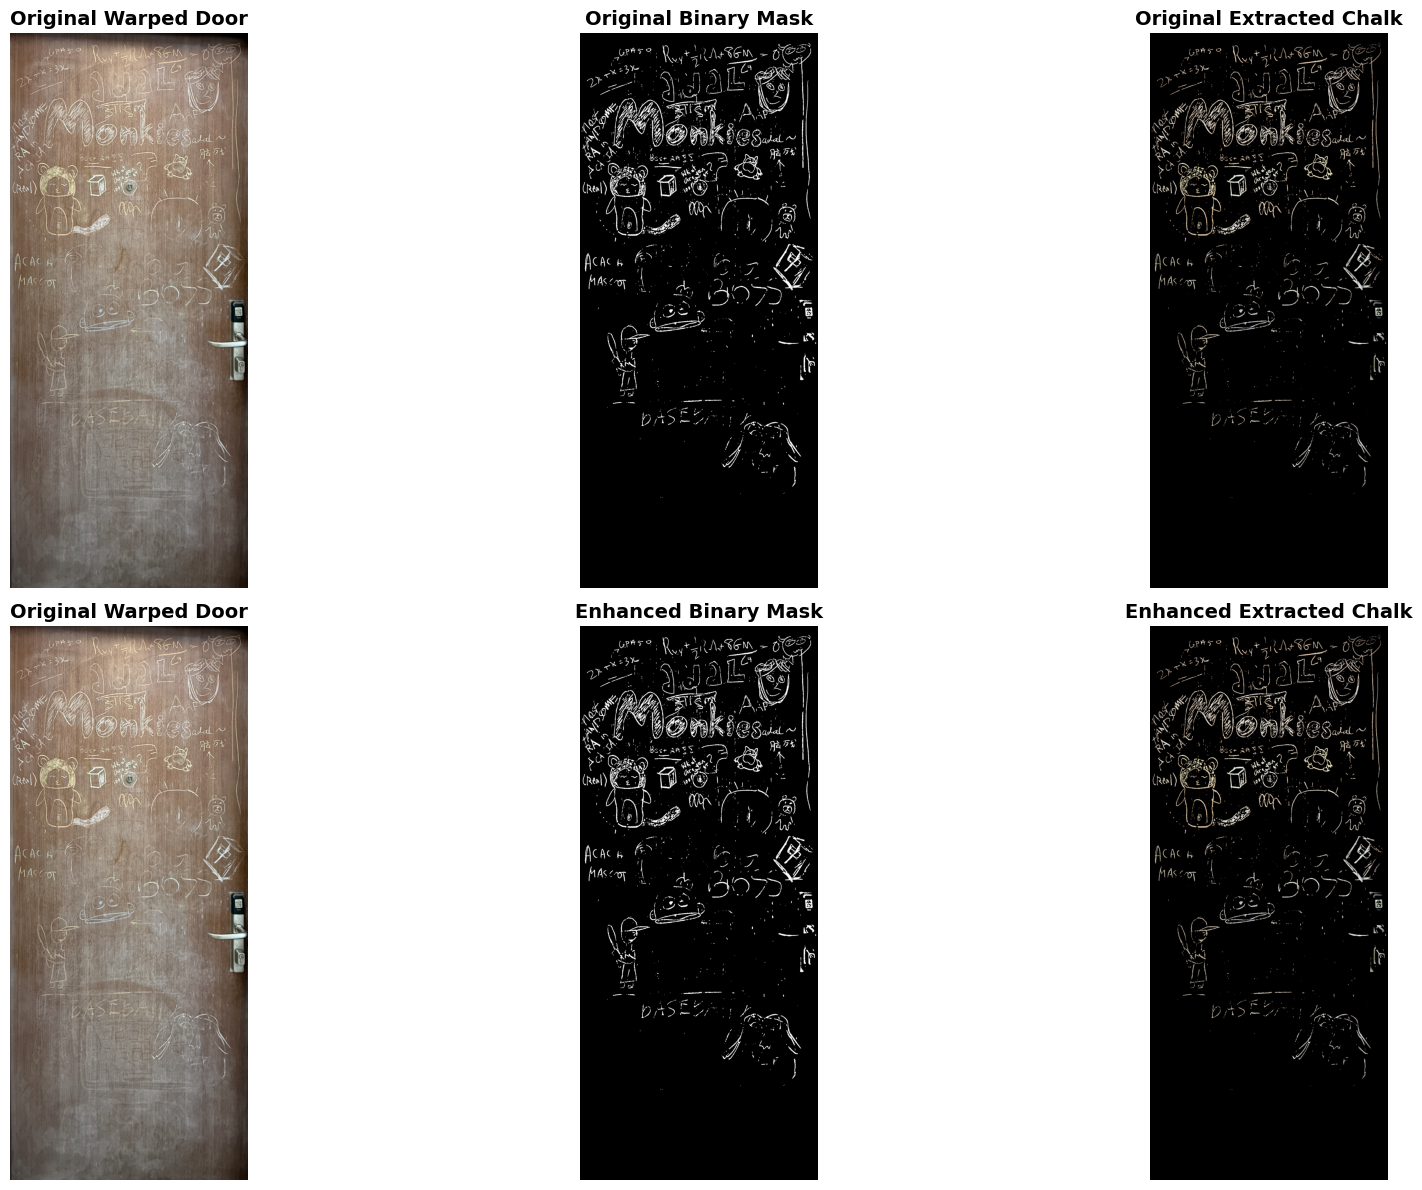


✓ Enhanced chalk extraction complete
  • Mask coverage: 173730 → 173730 pixels


In [91]:
def enhance_chalk_extraction(chalk_img, binary_mask, 
                            apply_dilation=True, 
                            apply_closing=True, 
                            apply_clahe=True,
                            dilation_kernel_size=(2, 2),
                            dilation_iterations=2,
                            closing_kernel_size=(2, 2)):
    """
    Enhance extracted chalk with improved contrast and thickness.
    
    Args:
        chalk_img: Color image with extracted chalk (BGR)
        binary_mask: Binary mask of chalk regions
        apply_dilation: Whether to dilate mask for thicker lines
        apply_closing: Whether to apply morphological closing
        apply_clahe: Whether to apply CLAHE contrast enhancement
        dilation_kernel_size: Kernel size for dilation
        dilation_iterations: Number of dilation iterations
        closing_kernel_size: Kernel size for morphological closing
    
    Returns:
        enhanced_chalk: Enhanced color chalk image
        enhanced_mask: Enhanced binary mask
    """
    enhanced_mask = binary_mask.copy()
    
    # 1. Dilate the binary mask to make chalk lines thicker
    if apply_dilation:
        dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, dilation_kernel_size)
        enhanced_mask = cv2.dilate(enhanced_mask, dilate_kernel, iterations=dilation_iterations)
        print("  ✓ Applied dilation")
    else:
        print("  ⊗ Skipped dilation")
    
    # 2. Apply morphological closing to connect nearby chalk strokes
    if apply_closing:
        close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, closing_kernel_size)
        enhanced_mask = cv2.morphologyEx(enhanced_mask, cv2.MORPH_CLOSE, close_kernel)
        print("  ✓ Applied morphological closing")
    else:
        print("  ⊗ Skipped morphological closing")
    
    # 3. Extract chalk with enhanced mask
    enhanced_chalk = cv2.bitwise_and(warped_img, warped_img, mask=enhanced_mask)
    
    # 4. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to each channel
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced_color = np.zeros_like(enhanced_chalk)
        
        for i in range(3):  # Process each BGR channel
            channel = enhanced_chalk[:, :, i]
            enhanced_channel = clahe.apply(channel)
            enhanced_channel = cv2.convertScaleAbs(enhanced_channel, alpha=1.3, beta=20)
            enhanced_color[:, :, i] = enhanced_channel
        
        enhanced_final = cv2.bitwise_and(enhanced_color, enhanced_color, mask=enhanced_mask)
        print("  ✓ Applied CLAHE contrast enhancement")
    else:
        enhanced_final = enhanced_chalk
        print("  ⊗ Skipped CLAHE contrast enhancement")
    
    return enhanced_final, enhanced_mask

# Apply enhancement with control panel settings
print("Applying enhancements...")
enhanced_chalk, enhanced_mask = enhance_chalk_extraction(
    chalk_color, 
    tophat_binary,
    apply_dilation=ENABLE_DILATION,
    apply_closing=ENABLE_MORPHOLOGICAL_CLOSING,
    apply_clahe=ENABLE_CLAHE,
    dilation_kernel_size=DILATION_KERNEL_SIZE,
    dilation_iterations=DILATION_ITERATIONS,
    closing_kernel_size=CLOSING_KERNEL_SIZE
)

# Display comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Top row: Original extraction
axes[0, 0].imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Warped Door", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(tophat_binary, cmap='gray')
axes[0, 1].set_title("Original Binary Mask", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(cv2.cvtColor(chalk_color, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title("Original Extracted Chalk", fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Bottom row: Enhanced extraction
axes[1, 0].imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Original Warped Door", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(enhanced_mask, cmap='gray')
axes[1, 1].set_title("Enhanced Binary Mask", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(cv2.cvtColor(enhanced_chalk, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title("Enhanced Extracted Chalk", fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Enhanced chalk extraction complete")
print(f"  • Mask coverage: {np.sum(tophat_binary > 0)} → {np.sum(enhanced_mask > 0)} pixels")


### Color Saturation Boost

Applying saturation boost...
  ✓ Applied saturation boost (1.25x)


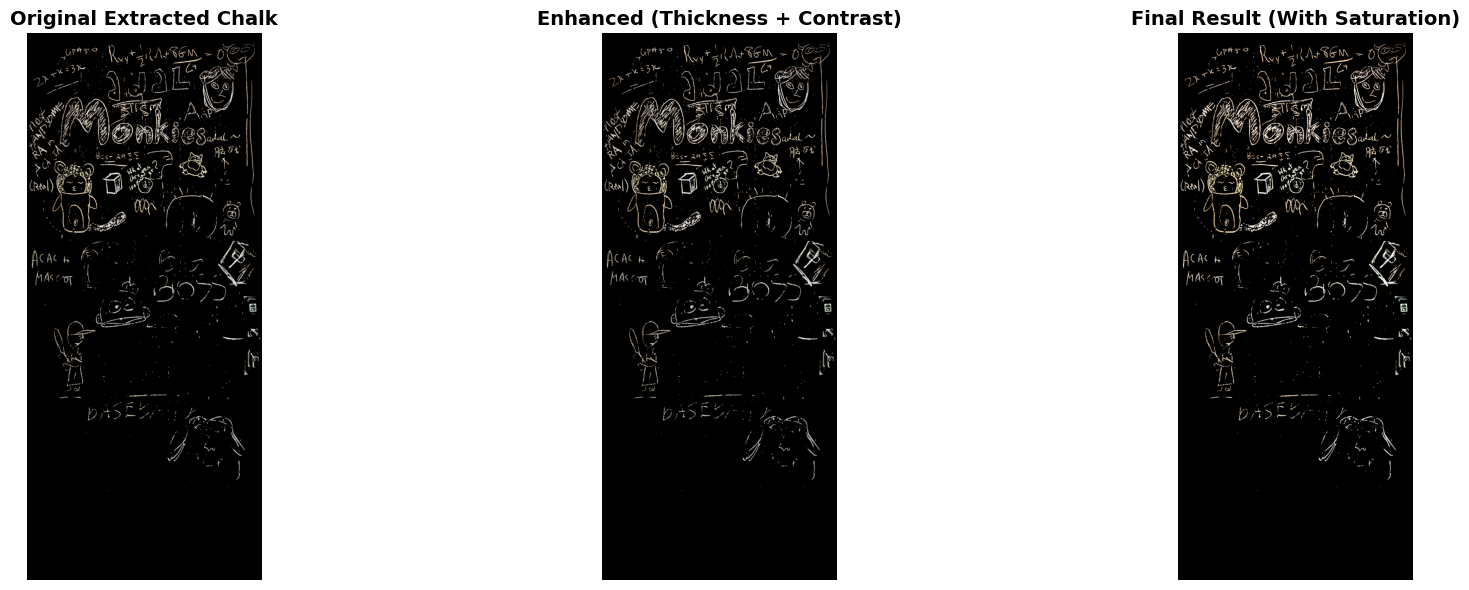


✓ Processing complete!


In [92]:
def boost_color_saturation(img, mask, apply_saturation=True, saturation_scale=1.8):
    """
    Boost color saturation to make each color more vibrant.
    
    Args:
        img: BGR image
        mask: Binary mask of regions to enhance
        apply_saturation: Whether to apply saturation boost
        saturation_scale: Multiplier for saturation (1.5-2.5 recommended)
    
    Returns:
        saturated_img: Image with boosted color saturation (or original if disabled)
    """
    if not apply_saturation:
        print("  ⊗ Skipped saturation boost")
        return img
    
    # Only work on masked regions
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    # Convert BGR to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HSV).astype(np.float32)
    
    # Split channels
    h, s, v = cv2.split(hsv)
    
    # Boost saturation - make colors more vivid
    s = s * saturation_scale
    s = np.clip(s, 0, 255)  # Keep values in valid range
    
    # Slightly boost value (brightness) too
    v = v * 1.2
    v = np.clip(v, 0, 255)
    
    # Merge back
    hsv_boosted = cv2.merge([h, s, v]).astype(np.uint8)
    
    # Convert back to BGR
    saturated_img = cv2.cvtColor(hsv_boosted, cv2.COLOR_HSV2BGR)
    
    print(f"  ✓ Applied saturation boost ({saturation_scale}x)")
    return saturated_img

# Apply saturation boost with control panel settings
print("Applying saturation boost...")
saturated_chalk = boost_color_saturation(
    enhanced_chalk, 
    enhanced_mask, 
    apply_saturation=ENABLE_SATURATION_BOOST,
    saturation_scale=SATURATION_MULTIPLIER
)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(chalk_color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Extracted Chalk", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(enhanced_chalk, cv2.COLOR_BGR2RGB))
axes[1].set_title("Enhanced (Thickness + Contrast)", fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(saturated_chalk, cv2.COLOR_BGR2RGB))
axes[2].set_title("Final Result (With Saturation)" if ENABLE_SATURATION_BOOST else "Final Result (No Saturation)", 
                  fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Processing complete!")

## Save Results

Saved results:
  - result_warped_door.jpg (original warped door)
  - result_chalk_extracted.jpg (extracted chalk in color)
  - result_chalk_enhanced.jpg (enhanced - thicker + contrast)
  - result_chalk_saturated.jpg (final - saturated colors)
  - result_tophat_color.jpg (top-hat filter result)
  - result_chalk_binary_mask.jpg (binary mask)
  - result_enhanced_mask.jpg (enhanced binary mask)


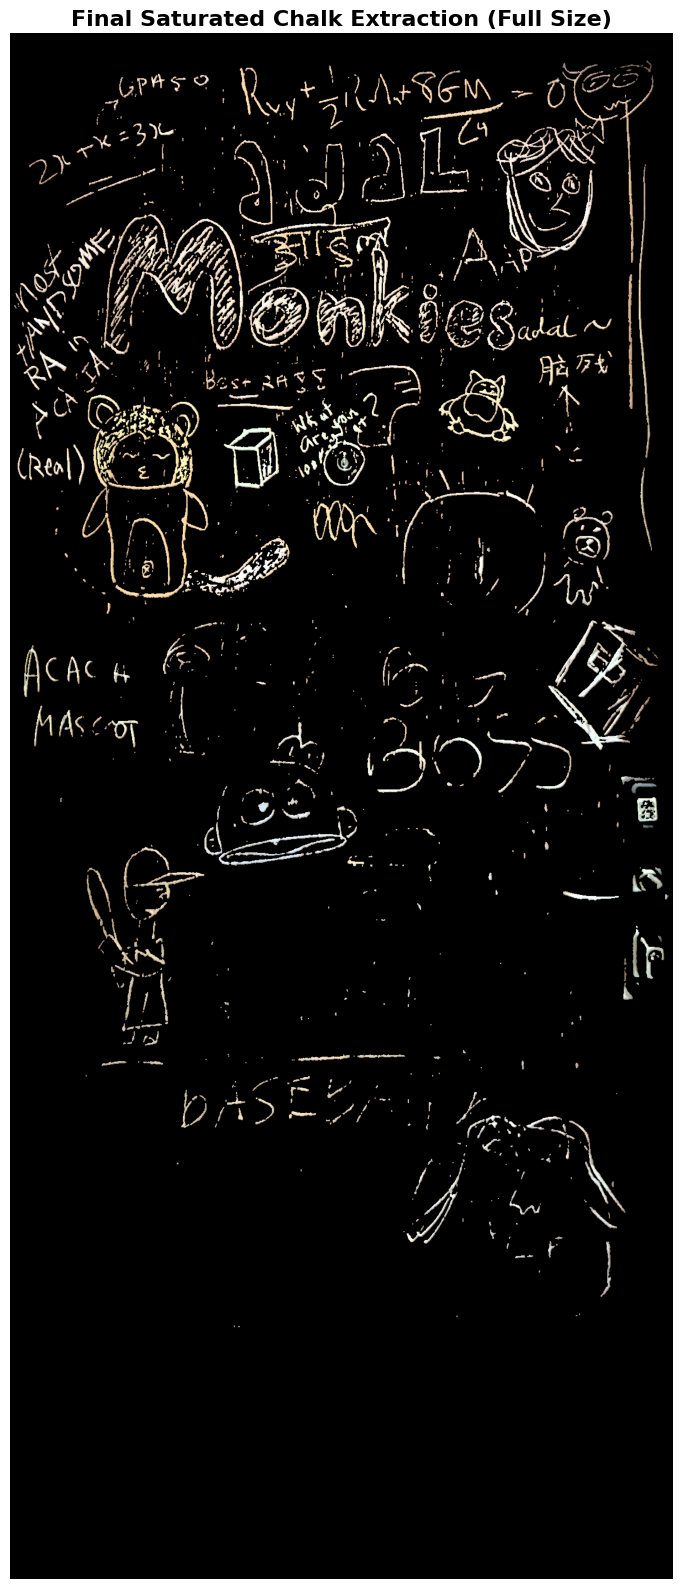


FINAL RESULT - SATURATED CHALK EXTRACTION
Processing pipeline:
  1. Top-Hat morphological transform
  2. Contrast enhancement (CLAHE)
  3. Line thickness increase (dilation)
  4. Color saturation boost (HSV)


In [93]:
# Save all result images
cv2.imwrite('result_warped_door.jpg', warped_img)
cv2.imwrite('result_chalk_extracted.jpg', chalk_color)
cv2.imwrite('result_chalk_enhanced.jpg', enhanced_chalk)
cv2.imwrite('result_chalk_saturated.jpg', saturated_chalk)
cv2.imwrite('result_tophat_color.jpg', tophat_color)
cv2.imwrite('result_chalk_binary_mask.jpg', tophat_binary)
cv2.imwrite('result_enhanced_mask.jpg', enhanced_mask)

print("Saved results:")
print("  - result_warped_door.jpg (original warped door)")
print("  - result_chalk_extracted.jpg (extracted chalk in color)")
print("  - result_chalk_enhanced.jpg (enhanced - thicker + contrast)")
print("  - result_chalk_saturated.jpg (final - saturated colors)")
print("  - result_tophat_color.jpg (top-hat filter result)")
print("  - result_chalk_binary_mask.jpg (binary mask)")
print("  - result_enhanced_mask.jpg (enhanced binary mask)")

# Display final result in full size for review
plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(saturated_chalk, cv2.COLOR_BGR2RGB))
plt.title("Final Saturated Chalk Extraction (Full Size)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINAL RESULT - SATURATED CHALK EXTRACTION")
print("="*60)
print("Processing pipeline:")
print("  1. Top-Hat morphological transform")
print("  2. Contrast enhancement (CLAHE)")
print("  3. Line thickness increase (dilation)")
print("  4. Color saturation boost (HSV)")
print("="*60)

In [95]:
import cv2

# Load an image
img = cv2.imread("result_chalk_saturated.jpg")

# Get dimensions
height, width = img.shape[:2]

print(f"Image Width: {width} pixels")
print(f"Image Height: {height} pixels")


Image Width: 1200 pixels
Image Height: 2800 pixels
